#  Tumor classification with mobilenet
dataset 
#  [here](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)


# Import libreries

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


# Set Up Paths and Parameters

In [7]:
# Paths to  dataset
train_dir = 'btdata/Training'
test_dir = 'btdata/Testing'

# Image size and batch size
img_size = 224  # MobileNet requires 224x224 images
batch_size = 32  #
num_classes = 4  # Notumor, Glioma, Pituitary, Meningioma


# Data Augmentation and Preprocessing

In [8]:
# Training Data Generator with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/Test Data Generator (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'  # Since this is multi-class classification
)

# Validation data
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# Load MobileNet Base Model

In [9]:
# Load MobileNet with pre-trained weights, without the top layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model layers so they are not trainable
base_model.trainable = False


# Build the Model

In [10]:
# Add custom layers on top of MobileNet
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dense(512, activation='relu')(x)  # Another fully connected layer

# Output layer (4 classes: Notumor, Glioma, Pituitary, Meningioma)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()  # Print model architecture


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,805,316 (18.33 MB)

 Trainable params: 1,576,452 (6.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

# Train the Model

In [11]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Adjust the number of epochs
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size
)


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.7515 - loss: 0.6374

D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 139s 765ms/step - accuracy: 0.7520 - loss: 0.6364 - val_accuracy: 0.8695 - val_loss: 0.3418
Epoch 2/20
  1/178 ━━━━━━━━━━━━━━━━━━━━ 1:17 440ms/step - accuracy: 0.9062 - loss: 0.3463

D:\Python\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.3463 - val_accuracy: 0.9032 - val_loss: 0.3813
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 134s 754ms/step - accuracy: 0.8922 - loss: 0.2849 - val_accuracy: 0.8672 - val_loss: 0.3576
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.4246 - val_accuracy: 0.8387 - val_loss: 0.4198
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 135s 756ms/step - accuracy: 0.9152 - loss: 0.2331 - val_accuracy: 0.8734 - val_loss: 0.3400
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.3530 - val_accuracy: 0.9032 - val_loss: 0.2967
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 141s 791ms/step - accuracy: 0.9272 - loss: 0.2093 - val_accuracy: 0.9062 - val_loss: 0.2439
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.2331 - val_accuracy: 0.9355 - val_loss: 0.2964
Epoch 9/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 138s 773ms/step - accuracy: 0.9281 - loss: 0.1812 - val_accurac

# Visualize Training Results (Accuracy & Loss)

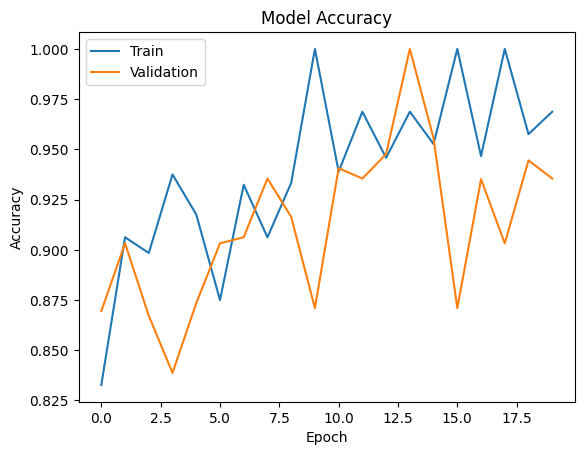

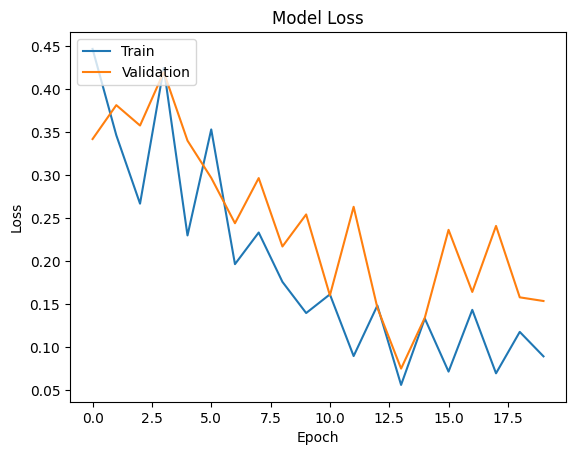

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Save the model

In [16]:

model.save('model/brain_tumor_classification_mobilenet.h5')


# Prediction validation and plotting confusion matrix with f1 score

In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

In [23]:
# Load the saved model
model = load_model('model/brain_tumor_classification_mobilenet.h5')

# Define the image size
img_size = 224  # Image size used for MobileNet (replace if different)

# Load and preprocess a test image
img_path = 't.jpg'  # Replace with the path to your test image
img = image.load_img(img_path, target_size=(img_size, img_size))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)

# Class mapping (adjust to your class indices)
class_indices = {0: 'notumor', 1: 'Glioma', 2: 'Pituitary', 3: 'Meningioma'}
print(f"Predicted class: {class_indices[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
Predicted class: Meningioma


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming your test set is in 'Dataset/Testing' folder, set the path
test_dir = 'btdata/Testing'

# Image data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generate predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes


Found 1311 images belonging to 4 classes.


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 448ms/step


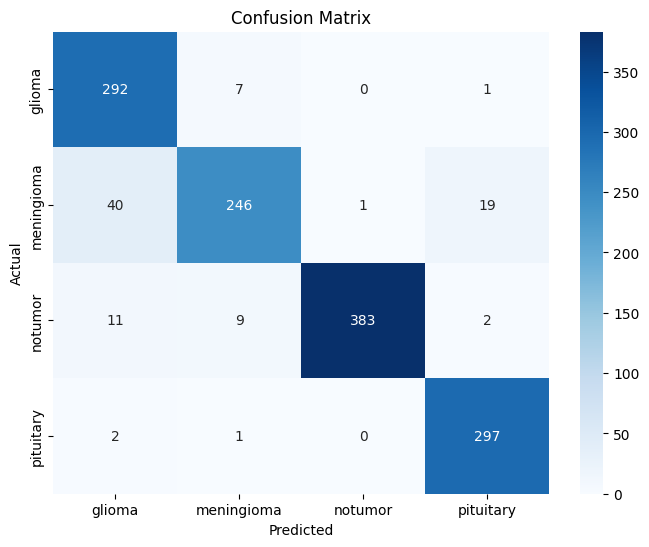

Classification Report:
              precision    recall  f1-score   support

      glioma       0.85      0.97      0.91       300
  meningioma       0.94      0.80      0.86       306
     notumor       1.00      0.95      0.97       405
   pituitary       0.93      0.99      0.96       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



In [25]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


In [26]:
# Generate predictions (from the previous step)
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes


41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 433ms/step


In [27]:
# Calculate F1 score for each class
f1 = f1_score(y_true, y_pred, average=None)  # F1 score for each class
print(f"F1 Score for each class: {f1}")

# Calculate macro and weighted F1 score
f1_macro = f1_score(y_true, y_pred, average='macro')  # Macro average F1 score
f1_weighted = f1_score(y_true, y_pred, average='weighted')  # Weighted average F1 score

print(f"Macro F1 Score: {f1_macro}")
print(f"Weighted F1 Score: {f1_weighted}")


F1 Score for each class: [0.90542636 0.86467487 0.97084918 0.95961228]
Macro F1 Score: 0.9251406697047131
Weighted F1 Score: 0.9285248027100635
